This notebook describes the procedure followed in the synthetic demonstration of the SSCP method in the main paper.

In [123]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib

In [124]:
# define the data generating process
def apply_step(x):
    """Simple step function applied to input x"""
    return (x + 1e-7) % 0.4 > 0.2


def sample_from_circle_circum(r: np.array):
    """
    Generates a dataset of inputs from a 1-dim np array of radii. Every input 
    (index i) consists of 10 2-dim points (i.e. each input is 20 dim) each 
    randomly sampled from the circumference of a circle with base at the origin
    and radius r[i].

    Args:
        r (np.array): 1-dim array containing the radius of each circle.
    """
    n_samples = 10
    n_circles = len(r)
    theta = np.random.rand(n_circles, n_samples) * 2 * np.pi
    x,y = np.cos(theta) * r[:,None], r[:,None] + np.sin(theta) * r[:,None]
    return np.hstack([x,y])

# now generate some data
np.random.seed(0)
N = 200  # number of labelled examples to generate

L = np.random.rand(N)  # first generate the latents
y_bool = apply_step(L)  # apply the step function
y = np.random.randn(N) * 0.1 + (1.5 * y_bool + 0.1 * ~y_bool) * np.random.choice([1, -1], size=N)  # and generate the labels
X = sample_from_circle_circum(L)  # finally generate the inputs


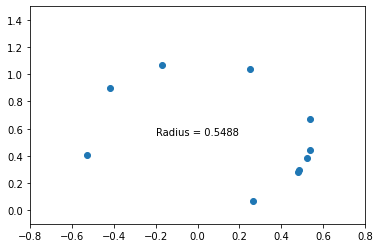

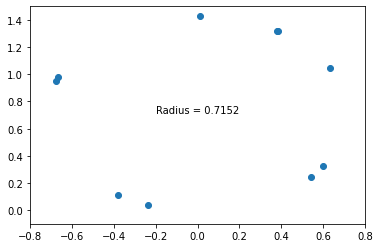

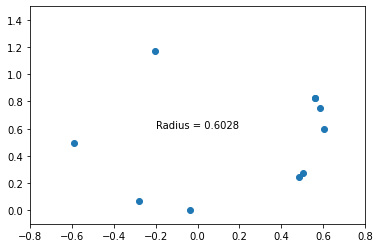

In [143]:
# Plot some sample inputs from the generated data. The randomly sampled latent value 
# dictates the radius of the circle from which we sample inputs along the circumference.

idx = 0
plt.scatter(X[:,:,None].reshape(200,2,10)[idx,0],X[:,:,None].reshape(200,2,10)[idx,1])
plt.text(x=-0.2, y=L[idx], s=f'Radius = {round(L[idx],4)}')
plt.ylim(-0.1,1.5)
plt.xlim(-0.8,0.8)
plt.show()

idx = 1
plt.scatter(X[:,:,None].reshape(200,2,10)[idx,0],X[:,:,None].reshape(200,2,10)[idx,1])
plt.text(x=-0.2, y=L[idx], s=f'Radius = {round(L[idx],4)}')
plt.ylim(-0.1,1.5)
plt.xlim(-0.8,0.8)
plt.show()

idx = 2
plt.scatter(X[:,:,None].reshape(200,2,10)[idx,0],X[:,:,None].reshape(200,2,10)[idx,1])
plt.text(x=-0.2, y=L[idx], s=f'Radius = {round(L[idx],4)}')
plt.ylim(-0.1,1.5)
plt.xlim(-0.8,0.8)
plt.show()

In [126]:
# Train the two conformal prediction models. One on the raw inputs, the other 
# augmented with an additional input corresponding to the latent (i.e. SSCP).
# In practice this latent would be estimated using a self supervised task but this 
# synthetic demonstration is designed such that the latent could conceptually be
# exactly obtained with a 1-dim autoencoder. Later experiments in the paper
# investigate more realistic data.

alpha = 1 - 0.9
scores = np.abs(y)

# train the residual model without the ss input
rf = RandomForestRegressor(oob_score=True, n_estimators=1000, ccp_alpha=0.11, random_state=0)
rf.fit(X, scores)
pred_residuals = rf.oob_prediction_

q_yhat = np.quantile(scores/pred_residuals, np.ceil((N+1)*(1-alpha))/N, interpolation='lower')

upper = pred_residuals * q_yhat

# train the residual model with the ss input
alpha = 1 - 0.9
rf_e = RandomForestRegressor(oob_score=True, n_estimators=1000, ccp_alpha=0.11, random_state=0)

X_extended = np.c_[X, L]

rf_e.fit(X_extended, scores)
pred_residuals_ss = rf_e.oob_prediction_

q_yhat = np.quantile(scores/pred_residuals_ss, np.ceil((N+1)*(1-alpha))/N, interpolation='lower')

upper_ss = pred_residuals_ss * q_yhat

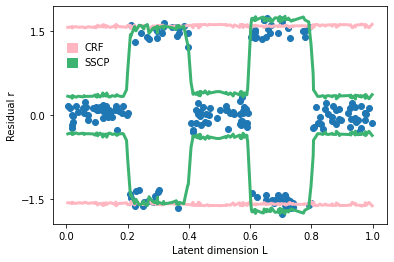

In [144]:
# finally we plot the resulting conformal intervals

matplotlib.rcParams['legend.handlelength'] = 1
matplotlib.rcParams['legend.handleheight'] = 1

plt.scatter(L, y)

idx = np.argsort(L)
plt.plot(L[idx], upper[idx], c='lightpink', linewidth=3, label='CRF')
plt.plot(L[idx], -upper[idx], c='lightpink', linewidth=3)

plt.plot(L[idx], upper_ss[idx], c='mediumseagreen', linewidth=3, label='SSCP')
plt.plot(L[idx], -upper_ss[idx], c='mediumseagreen', linewidth=3)

plt.yticks([1.5, 0, -1.5])
plt.ylabel('Residual r')
plt.xlabel('Latent dimension L')

legend_elements = [Patch(facecolor='lightpink', edgecolor='lightpink',
                         label='CRF'),
                   Patch(facecolor='mediumseagreen', edgecolor='mediumseagreen',
                         label='SSCP')]
plt.legend(handles=legend_elements, loc=(0.03,0.7), frameon=False)

plt.show()